In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import networkx as nx
from scipy.optimize import minimize

from docplex.mp.model import Model
from collections import defaultdict
from openqaoa.problems.converters import FromDocplex2IsingModel # function to translate docplex problems into Ising Hamiltonians

import networkx as nx
import numpy as np
import time
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator

from qiskit_aer import AerSimulator
backend = AerSimulator()

colors = plt.get_cmap("jet", 20)

label_size = 14
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 
plt.rcParams['axes.labelsize'] = label_size 
plt.rcParams['legend.fontsize'] = label_size 

In [2]:
def QUBO(mu, sigma, budget, asset_cost, risk_factor=1):
    # Portfolio Optimization as a QUBO problem
    mdl = Model('PortfolioOptimization')
    num_vertices = len(mu)
    x = mdl.binary_var_list(num_vertices, name="x")
    cost = 0
    for i in range(num_vertices):
        cost -= mu[i] * x[i]
        for j in range(i+1, num_vertices):
            cost += risk_factor * sigma[i,j] * x[i] * x[j]
    mdl.minimize(cost)
    mdl.add_constraint(mdl.sum(asset_cost[i] * x[i] for i in range(num_vertices)) <= budget)
    return mdl

def cost(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] + x[j] in ["01","10"]:
            obj += G[i][j]["weight"]
    return - obj

def energy(x, hamiltonian):
    obj = 0
    spin = {"1":-1, "0":1}
    for k, v in hamiltonian.items():
        if len(k) == 2:
            obj += v * spin[x[k[0]]] * spin[x[k[1]]]
        elif len(k) == 1:
            obj += v * spin[x[k[0]]]
        else:
            print(k, v)
    return obj


def qaoa_circ(hamiltonian, gammas, betas, n_qubits):
    p = len(gammas)
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    for ii in range(p):
        for qbits, value in hamiltonian.items():
            if len(qbits) == 1:
                qc.rz(2*gammas[ii]*float(value), qbits[0])
        for qbits, value in hamiltonian.items():
            if len(qbits) == 2:
                qc.rzz(2*gammas[ii]*float(value), *qbits)
        qc.rx(-2*betas[ii], range(n_qubits))
    qc = qc.reverse_bits()
    qc.measure_all()
    return qc

In [68]:
np.random.seed(1)
problems = np.load("./Data/PO/problems.npy", allow_pickle=True).item()

nodes_list_qubo = range(21, 36)
random_cases = 100
# Generate graphs with the above condition for different number of nodes
for nodes in nodes_list_qubo:
    print(f"-------     qubits: {nodes}    ---------")
    problems[nodes] = {}
    for kk in range(random_cases):
        problems[nodes][kk] = {}
        mu = np.random.rand(nodes)
        sigma = np.random.choice([-0.1, 0, 0.1, 0.2], size=(nodes, nodes))
        asset_cost = np.random.rand(nodes) + 0.5 
        budget = 0.5 * np.sum(asset_cost)
        mdl = QUBO(mu, sigma, budget, asset_cost)
        mdl.solve()
        problems[nodes][kk]["real_sol"] = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())
        qubo = FromDocplex2IsingModel(mdl, unbalanced_const=True, strength_ineq=[0.96842017, 0.05990213])
        ising_hamiltonian = qubo.ising_model
        # max_w = np.max(np.abs(ising_hamiltonian.weights))
        max_w = np.max(np.abs([w for w, qbs in zip(ising_hamiltonian.weights, ising_hamiltonian.terms) if len(qbs)>1]))
        ising_hamiltonian.weights = [w/max_w for w in ising_hamiltonian.weights]
        ising_hamiltonian.constant = ising_hamiltonian.constant/max_w
        problems[nodes][kk]["ising"] = {tuple(k): v for k, v in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if abs(v) > 1e-6}
        new_mdl = qubo.qubo_docplex
        new_mdl.solve()
        problems[nodes][kk]["sol"] = "".join(str(round(new_mdl.solution.get_value(var))) for var in new_mdl.iter_binary_vars())
        problems[nodes][kk]["opt_energy"] = energy(problems[nodes][kk]["sol"], problems[nodes][kk]["ising"])#*max_w + max_w* ising_hamiltonian.constant

np.save("./Data/PO/problems.npy", problems)

-------     qubits: 21    ---------
-------     qubits: 22    ---------
-------     qubits: 23    ---------
-------     qubits: 24    ---------
-------     qubits: 25    ---------
-------     qubits: 26    ---------
-------     qubits: 27    ---------
-------     qubits: 28    ---------
-------     qubits: 29    ---------
-------     qubits: 30    ---------
-------     qubits: 31    ---------
-------     qubits: 32    ---------


In [15]:
problems = np.load("./Data/PO/problems.npy", allow_pickle=True).item()

In [11]:
method = "hpc"
problems = np.load("./Data/PO/problems.npy", allow_pickle=True).item()

ps = [10,25,50,100,200]
# ps = [200]
# delta_betas = {[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# delta_betas = np.linspace(0.01, 0.1, 10)
# delta_gammas = [0.1,0.2,0.3,0.4,0.5,0.6]
list_gammas ={25:[0.35, 0.4, 0.45, 0.5, 0.55],
              30:[0.3, 0.4, 0.5, 0.6],
              35:[0.35,0.4,0.45,0.5]}
list_betas = {25:[0.2, 0.3, 0.4, 0.5],
              30:[0.2, 0.3, 0.4, 0.5],
              35:[0.2,0.3,0.4,0.5]}
# delta_gammas = [0.5, 0.6, 0.7, 0.8]
nqs = [35]
cases = [0]
shots = 1000
results = np.load("./Data/PO/results.npy", allow_pickle=True).item()
for nq in nqs:
    print(f"---------   nq = {nq}   --------")
    results[nq] = {}
    for kk in cases:
        print(f"---------   case = {kk}   --------")
        results[nq][kk] = {}
        opt_energy = round(problems[nq][kk]["opt_energy"],3)
        hamiltonian = problems[nq][kk]["ising"]
        results[nq][kk]["energies"] = {}
        results[nq][kk]["landscape"]={}
        results[nq][kk]["best"] = {}
        for p in ps:
            best_probability = 0
            print(f"---------   p = {p}   --------")
            results[nq][kk]["energies"][p] = {}
            results[nq][kk]["landscape"][p] = {"energy":np.zeros((len(list_betas[nq]), len(list_gammas[nq]))), "probability":np.zeros((len(list_betas[nq]), len(list_gammas[nq])))}
            nn = 0
            for i, delta_beta in enumerate(list_betas[nq]):
                for j, delta_gamma in enumerate(list_gammas[nq]):
                    if method == "local":
                        gammas = np.arange(1, p+1) * delta_gamma/p
                        betas = np.arange(1, p+1)[::-1] * delta_beta/p
                        qc = qaoa_circ(hamiltonian, gammas, betas, nq)
                        qc = transpile(qc, backend=backend)
                        samples = backend.run(qc, shots=shots).result().get_counts()
                    elif method == "hpc":
                        with open(f"./Data/PO/samples_hpc/{nq}/{kk}/{p}/{nn}.out", "r") as file:
                            lines = file.readlines()
                        samples = defaultdict(int)
                        for line in lines[2:]:
                            columns = line.split()
                            samples[columns[0][1:-1][::-1]] += int(columns[-1])
                        shots = 10000
                        nn += 1
                    energies = defaultdict(int)
                    mean_energy = 0
                    for sample, c in samples.items():
                        e = round(energy(sample, hamiltonian), 3)
                        energies[e] += c
                        mean_energy += e*c
                    mean_energy /= shots 
                    probability = energies[opt_energy]/shots if opt_energy in energies else 0
                    results[nq][kk]["energies"][p][(delta_beta, delta_gamma)] = energies
                    results[nq][kk]["landscape"][p]["energy"][i,j] = mean_energy
                    results[nq][kk]["landscape"][p]["probability"][i,j] = probability
                    if probability > best_probability:
                        best_probability = probability
                        results[nq][kk]["best"][p] = {"probabiliy":probability, "delta_beta":delta_beta, "delta_gamma":delta_gamma, "energy":mean_energy}
                        print(f"beta:{delta_beta} | gamma: {delta_gamma}, probability: {probability}, mean energy: {mean_energy}")
np.save("./Data/PO/results.npy", results)

---------   nq = 35   --------
---------   case = 0   --------
---------   p = 10   --------
beta:0.2 | gamma: 0.35, probability: 0.0001, mean energy: -73.2101808999998
beta:0.2 | gamma: 0.4, probability: 0.0002, mean energy: -70.60036339999998
beta:0.2 | gamma: 0.45, probability: 0.0003, mean energy: -67.91135770000001
beta:0.3 | gamma: 0.35, probability: 0.0063, mean energy: -89.86742740000004
beta:0.3 | gamma: 0.4, probability: 0.0068, mean energy: -87.15178120000043
beta:0.4 | gamma: 0.35, probability: 0.0501, mean energy: -97.91118559999998
beta:0.5 | gamma: 0.35, probability: 0.0966, mean energy: -100.6390193
---------   p = 25   --------
beta:0.2 | gamma: 0.35, probability: 0.0252, mean energy: -94.27987690000023
beta:0.3 | gamma: 0.35, probability: 0.2592, mean energy: -105.04009529999958
beta:0.4 | gamma: 0.35, probability: 0.4965, mean energy: -108.04159850000006
beta:0.5 | gamma: 0.35, probability: 0.5764, mean energy: -107.82107910000035
---------   p = 50   --------
beta:0

In [50]:
kk = 0
nq = 30
print(f'betas = ',{p:results[nq][kk]["best"][p]["delta_beta"] for p in [10,25,50,100,200]})
print(f'gammas = ',{p:results[nq][kk]["best"][p]["delta_gamma"] for p in [10,25,50,100,200]})



betas =  {10: 0.5, 25: 0.4, 50: 0.4, 100: 0.4, 200: 0.3}
gammas =  {10: 0.4, 25: 0.4, 50: 0.5, 100: 0.4, 200: 0.4}


In [25]:
ps = [10,25,50,100,200]
# ps = [25]
nqs = [35]
method = "hpc"
problems = np.load("./Data/PO/problems.npy", allow_pickle=True).item()
cases = range(1, 100)
shots = 1000
results = np.load("./Data/PO/results.npy", allow_pickle=True).item()
for nq in nqs:
    print(f"---------   nq = {nq}   --------")
    for kk in cases:
        print(f"---------   case = {kk}   --------")
        results[nq][kk] = {}
        opt_energy = round(problems[nq][kk]["opt_energy"],3)
        hamiltonian = problems[nq][kk]["ising"]
        # G = problems[nq][kk]["G"]
        results[nq][kk]["best"] = {}
        for p in ps:
            if method == "local":
                
                    if nq > 5 and nq < 21: 
                        delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq-1, nq, nq+1]])
                        delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq-1, nq, nq+1]])
                    elif nq == 5:    
                        delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq, nq+1]])
                        delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq, nq+1]])
                    elif nq == 21:    
                        delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq-1, nq]])
                        delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq-1, nq]])
                    else:
                        print("here")
                    gammas = np.arange(1, p+1) * delta_gamma/p
                    betas = np.arange(1, p+1)[::-1] * delta_beta/p
                    qc = qaoa_circ(hamiltonian, gammas, betas, nq)
                    qc = transpile(qc, backend=backend)
                    samples = backend.run(qc, shots=shots).result().get_counts()
            elif method == "hpc":
                delta_gamma = results[nq][0]["best"][p]["delta_gamma"]
                delta_beta = results[nq][0]["best"][p]["delta_beta"]
                with open(f"./Data/PO/samples_hpc/{nq}/{kk}/{p}/0.out", "r") as file:
                    lines = file.readlines()
                samples = defaultdict(int)
                for line in lines[2:]:
                    columns = line.split()
                    samples[columns[0][1:-1][::-1]] += int(columns[-1])
                shots = 10_000
                
            energies = defaultdict(int)
            mean_energy = 0
            for sample, c in samples.items():
                e = round(energy(sample, hamiltonian), 3)
                energies[e] += c
                mean_energy += e*c
            mean_energy /= shots 
            probability = energies[opt_energy]/shots if opt_energy in energies else 0
            results[nq][kk]["best"][p] = {"probabiliy":probability, "delta_beta":delta_beta, "delta_gamma":delta_gamma, "energy":mean_energy}
            print(f"p:{p} | beta:{delta_beta} | gamma: {delta_gamma}, probability: {probability}, mean energy: {mean_energy}")
np.save("./Data/PO/results.npy", results)

---------   nq = 35   --------
---------   case = 1   --------
p:10 | beta:0.5 | gamma: 0.35, probability: 0.0065, mean energy: -93.12065009999984
p:25 | beta:0.5 | gamma: 0.35, probability: 0.0996, mean energy: -99.0411821000001
p:50 | beta:0.5 | gamma: 0.35, probability: 0.2538, mean energy: -100.14387849999963
p:100 | beta:0.4 | gamma: 0.35, probability: 0.6874, mean energy: -102.396268
p:200 | beta:0.3 | gamma: 0.35, probability: 0.8883, mean energy: -103.41831039999992
---------   case = 2   --------
p:10 | beta:0.5 | gamma: 0.35, probability: 0.0302, mean energy: -79.27844169999992
p:25 | beta:0.5 | gamma: 0.35, probability: 0.33, mean energy: -84.75799820000009
p:50 | beta:0.5 | gamma: 0.35, probability: 0.7837, mean energy: -86.19866850000001
p:100 | beta:0.4 | gamma: 0.35, probability: 0.9078, mean energy: -87.61138729999993
p:200 | beta:0.3 | gamma: 0.35, probability: 0.9696, mean energy: -87.93585130000002
---------   case = 3   --------
p:10 | beta:0.5 | gamma: 0.35, probab

In [6]:
results = np.load("./Data/PO/results.npy", allow_pickle=True).item()

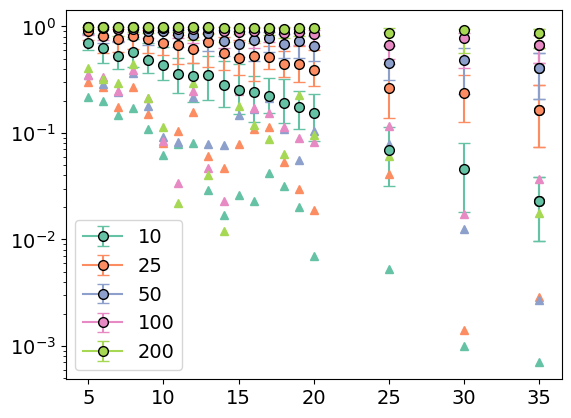

In [26]:
fig, ax  = plt.subplots()
sort = defaultdict(dict)
colors = plt.get_cmap("Set2")
for i, p in enumerate([10,25,50,100,200]):
    for nq in sorted(results.keys()):
        y = [results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]
        quartiles = np.percentile(np.array(y), [25, 50, 75])
        sort[p][nq] = quartiles[1]
        ax.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black")
    ax.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black", label=p)

    y_min = [np.min([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    std = [np.std([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    # plt.errorbar(sorted(results.keys()), y, std , marker="o", label=p, color=colors(3*i), capsize=3)
    ax.plot(sorted(results.keys()), y_min , marker="^", linewidth=0, color=colors(i))
nqs = range(5, 20)
# plt.plot(nqs, [1/2**nq for nq in nqs], linestyle="--", color="black")
ax.legend()
ax.set_yscale("log")

Text(0.5, 0, '$p$')

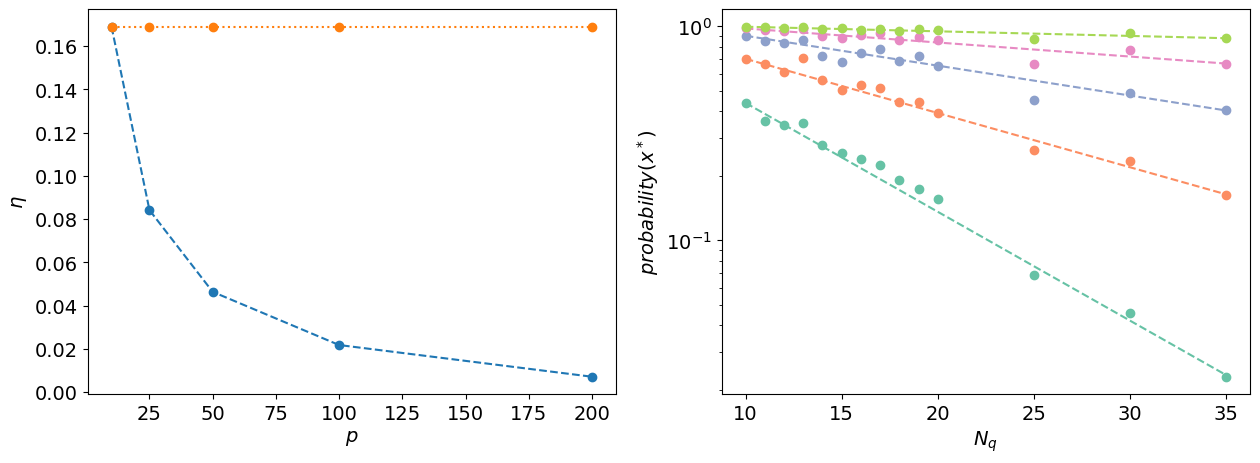

In [27]:
def func(x, p, nqs, y_real):
    """C:constant, eta:important value of the scale"""
    eta = x[0]
    C = x[1]
    y_eff = np.array([-eta*(nq - nqs[0]) for nq in nqs])
    return ((y_eff[:-1] - y_real[:-1])**2).mean() +  (y_eff[-1] - y_real[-1])**2

colors = plt.get_cmap("Set2")
ps = [10,25,50,100,200]
etas = {}
Cs = {}
error = {}
fig, ax = plt.subplots(1,2, figsize=(15,5))
for p in ps:
    nqs = list(range(10,21)) + [25,30,35]
    y_real = [np.log2(sort[p][nq]/sort[p][nqs[0]]) for nq in nqs]
    x0 = [0.5 , 0.1]
    sol = minimize(func, x0, args=(p, nqs, y_real))
    etas[p] = sol.x[0]
    Cs[p] = sol.x[1]
    error[p] = sol.fun

ax[0].plot(sorted(ps), [etas[p] for p in sorted(ps)], marker="o", linestyle="--")
ax[0].plot(sorted(ps), [etas[ps[0]] for p in sorted(ps)], marker="o", linestyle=":")

for i, p in enumerate(sort.keys()):
    ax[1].plot(nqs, [np.mean(sort[p][nq]) for nq in nqs], marker="o", linewidth=0, color=colors(i))
    ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[p]*(nq - nqs[0])) for nq in nqs], linestyle="--", color=colors(i))
    # ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[ps[0]]*(nq - nqs[0])) for nq in nqs], linestyle=":", color=colors(i))

ax[1].set_yscale("log")
ax[1].set_ylabel(r"$probability(x^*)$")
ax[1].set_xlabel(r"$N_q$")
ax[0].set_ylabel(r"$\eta$")
ax[0].set_xlabel(r"$p$")
# ax[0].set_yscale("log")


Text(0, 0.5, '$\\gamma$')

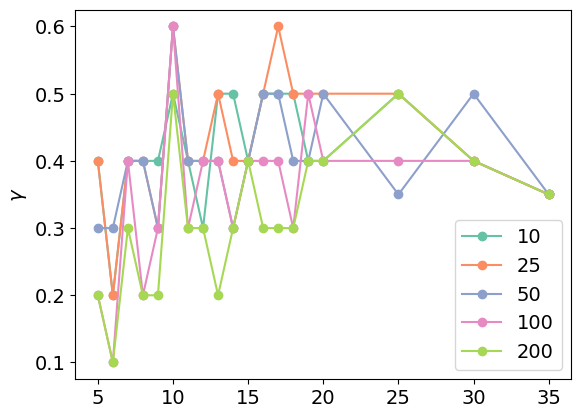

In [19]:
kk = 0
for i, p in enumerate(ps):
    plt.plot(sorted(results.keys()), [results[nq][kk]["best"][p]["delta_gamma"] for nq in sorted(results.keys())], marker="o", label=p, color=colors(i))
plt.legend()
plt.ylabel(r"$\gamma$")

Text(0, 0.5, '$\\beta$')

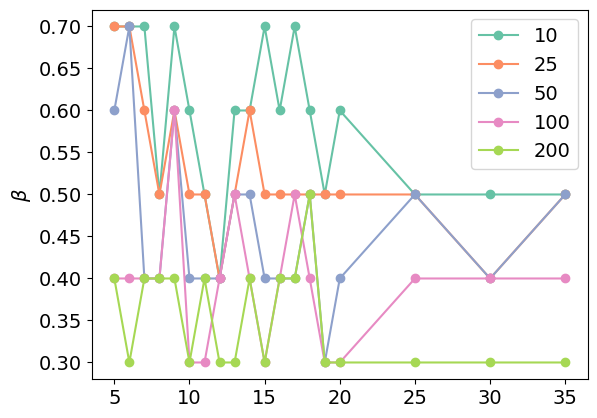

In [20]:
kk = 0
for i, p in enumerate(ps):
    plt.plot(sorted(results.keys()), [results[nq][kk]["best"][p]["delta_beta"] for nq in sorted(results.keys())], marker="o", label=p, color=colors(i))
plt.legend()
plt.ylabel(r"$\beta$")

In [22]:
kk = 0
nqs = [35]

print("gammas ->", {p:float(np.mean([results[nq][kk]["best"][p]["delta_gamma"] for nq in nqs])) for p in [10,25,50,100,200]})
print("betas ->", {p:float(np.mean([results[nq][kk]["best"][p]["delta_beta"]for nq in nqs])) for p in [10,25,50,100,200]})


gammas -> {10: 0.35, 25: 0.35, 50: 0.35, 100: 0.35, 200: 0.35}
betas -> {10: 0.5, 25: 0.5, 50: 0.5, 100: 0.4, 200: 0.3}


In [82]:
kk = 0
nq = 30
print("betas ->", {p:results[nq][kk]["best"][p]["delta_beta"] for p in [10,25,50,100,200]})
print("gammas ->", {p:results[nq][kk]["best"][p]["delta_gamma"] for p in [10,25,50,100,200]})

betas -> {10: 0.5, 25: 0.4, 50: 0.4, 100: 0.4, 200: 0.3}
gammas -> {10: 0.4, 25: 0.4, 50: 0.5, 100: 0.4, 200: 0.4}


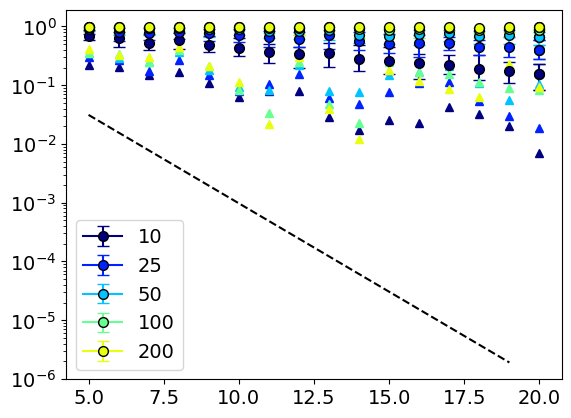

In [63]:
for i, p in enumerate([10,25,50,100,200]):
    for nq in sorted(results.keys()):
        y = [results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]
        quartiles = np.percentile(np.array(y), [25, 50, 75])
        plt.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(3*i), capsize=4, markersize=7, markeredgecolor="black")
    plt.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(3*i), capsize=4, markersize=7, markeredgecolor="black", label=p)

    y_min = [np.min([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    std = [np.std([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    # plt.errorbar(sorted(results.keys()), y, std , marker="o", label=p, color=colors(3*i), capsize=3)
    plt.plot(sorted(results.keys()), y_min , marker="^", linewidth=0, color=colors(3*i))
nqs = range(5, 20)
plt.plot(nqs, [1/2**nq for nq in nqs], linestyle="--", color="black")
plt.legend()
plt.yscale("log")